In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, wget, shutil
from scipy.stats import pearsonr
from itertools import combinations
import math, shap

/usr/local/fsl6.0.7/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
os.makedirs("data", exist_ok=True)
link_original = "https://s3.amazonaws.com/openneuro.org/ds004148/participants.tsv?versionId=wt81Mu2B3fdeiXSis5ym288A64lXRXkR"
wget.download(link_original)
filename = "participants.tsv"
file_ = [os.path.join(root, file) for root, _, files in os.walk(os.getcwd()) for file in files if file == filename]
shutil.copy2(file_[0], "data")
os.remove(file_[0])
print(f"\nOriginal file downloaded.")

df = pd.read_csv("data/" + filename, delim_whitespace="\t")
df = df[["age", "Weight", "Height"]]
df.head(3)

100% [..........................................................] 39886 / 39886
Original file downloaded.


,age,Weight,Height
0,19,58.0,178.0
1,19,49.0,155.0
2,19,46.0,169.0


In [ ]:
def user_output(clean_data):
    pipeline_output = np.mean(clean_data)
    return pipeline_output

def dp(clean_data, pipeline_output):
    user_output_variable = np.array([user_output(np.delete(clean_data, i)) for i in range(len(clean_data))])
    
    loo_mean = np.mean(user_output_variable)
    loo_scale = np.std(user_output_variable)
    sensitivity = np.max(np.abs(loo_mean - pipeline_output))
    
    while True:
        noise = np.random.laplace(loc=0.0, scale=np.median(loo_scale))
        if abs(noise) >= sensitivity:
            break
    
    return pipeline_output + noise

class DPExplainer:
    def __init__(self, data):
        self.data = data
        
    def __call__(self, instances):
        results = []
        for instance in instances:
            true_output = user_output(instance)
            noisy_output = dp(instance, true_output)
            mse = (true_output - noisy_output)**2
            results.append(mse)
        return np.array(results)

def dp_shap(data, n_samples=100):
    explainer = shap.KernelExplainer(
        DPExplainer(data).__call__,
        shap.sample(data, n_samples),  
        feature_names=["age", "Weight", "Height"]
    )
    shap_values = explainer.shap_values(data)
    mean_shap = np.abs(shap_values).mean(axis=0)
    return dict(zip(["age", "Weight", "Height"], mean_shap))

shapley_results = dp_shap(df.values)
print("\nSHAP Values:")
for dim, sv in shapley_results.items():
    print(f"{dim}: {sv:.4f}")

plt.bar(shapley_results.keys(), shapley_results.values())
plt.title("SHAP Values")
plt.xlabel("Dimension")
plt.ylabel("Mean |SHAP Value|")
plt.show()

data shape before: (60, 3)
data shape after: (58, 3)


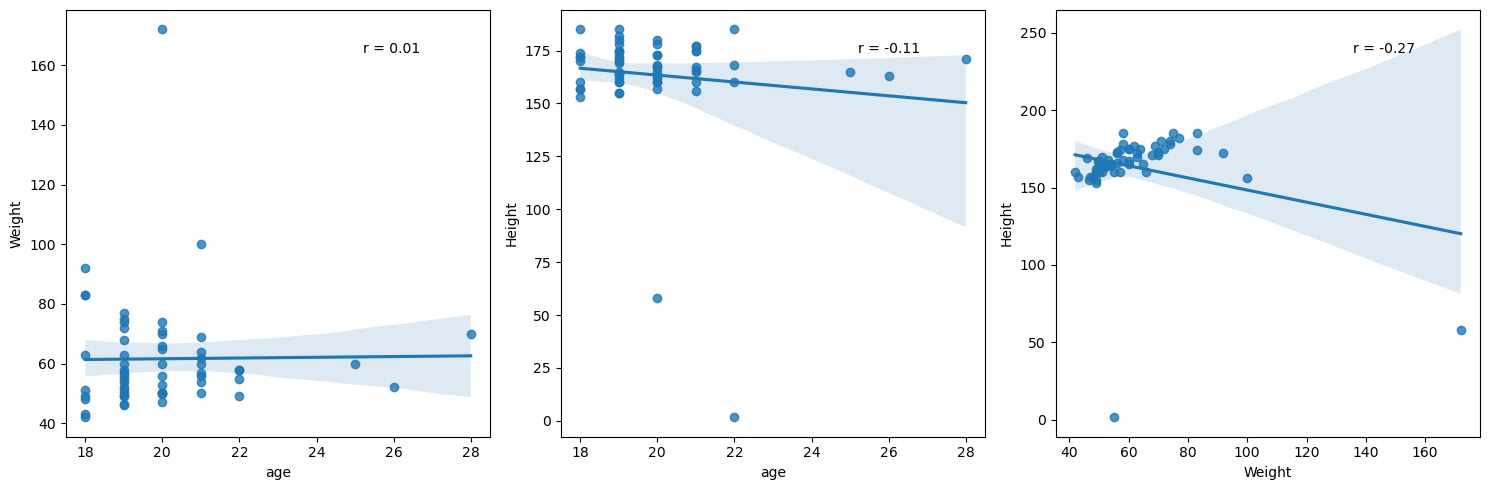

In [4]:
print(f"data shape before: {df.shape}")
df_cleaned = df.dropna()
print(f"data shape after: {df_cleaned.shape}")

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.regplot(x='age', y='Weight', data=df_cleaned)
r, _ = pearsonr(df_cleaned['age'], df_cleaned['Weight'])
plt.annotate(f'r = {r:.2f}', xy=(0.7, 0.9), xycoords='axes fraction')

plt.subplot(1, 3, 2)
sns.regplot(x='age', y='Height', data=df_cleaned)
r, _ = pearsonr(df_cleaned['age'], df_cleaned['Height'])
plt.annotate(f'r = {r:.2f}', xy=(0.7, 0.9), xycoords='axes fraction')

plt.subplot(1, 3, 3)
sns.regplot(x='Weight', y='Height', data=df_cleaned)
r, _ = pearsonr(df_cleaned['Weight'], df_cleaned['Height'])
plt.annotate(f'r = {r:.2f}', xy=(0.7, 0.9), xycoords='axes fraction')

plt.tight_layout()
plt.show()

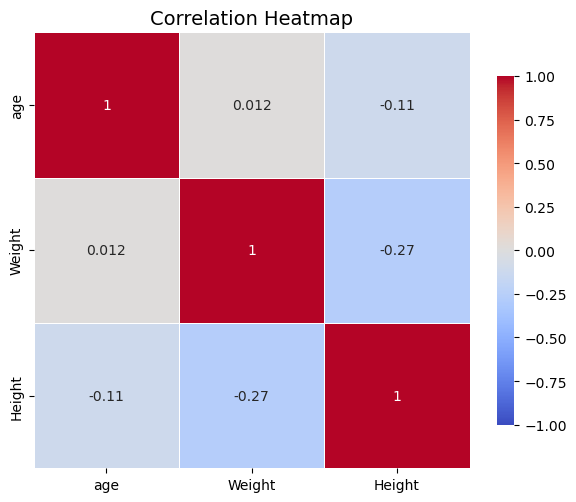

In [5]:
cor_mat = df.corr()

plt.figure(figsize=(6, 5))
sns.heatmap(cor_mat, annot=True, cmap='coolwarm',
            vmin=-1, vmax=1, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap', fontsize=14)
plt.tight_layout()
plt.show()
